In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import itertools
import math
import xgboost as xgb
from collections import Counter
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import plot_importance



%matplotlib inline


# EDA

In [ ]:
raw_df = pd.read_csv('income_pred.csv')
raw_df.head()

,ID,age,workclass,fnlwgt:,education:,education-num:,marital-status:,occupation:,relationship:,race:,sex:,capital-gain:,capital-loss:,hours-per-week:,native-country:,class
0,1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,4,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               32561 non-null  int64 
 1   age              32561 non-null  int64 
 2   workclass        32561 non-null  object
 3   fnlwgt:          32561 non-null  int64 
 4   education:       32561 non-null  object
 5   education-num:   32561 non-null  int64 
 6   marital-status:  32561 non-null  object
 7   occupation:      32561 non-null  object
 8   relationship:    32561 non-null  object
 9   race:            32561 non-null  object
 10  sex:             32561 non-null  object
 11  capital-gain:    32561 non-null  int64 
 12  capital-loss:    32561 non-null  int64 
 13  hours-per-week:  32561 non-null  int64 
 14  native-country:  32561 non-null  object
 15  class            32561 non-null  object
dtypes: int64(7), object(9)
memory usage: 4.0+ MB


Lets go over the columns:
 - ID: probably irrelevant
 - age: probably plays a role
 - workclass: probably relevant as well
 - fnlwgt: after googling - final weight. In other words, this is the number of people the census believes the entry represents
 - education: probably has some influence, we should probably treat it as ordinary
 - education-num: is this education but just ordinary?
 - marital status: probably has little to do with the target
 - occupation: this might have some importants, I think we can do some feature extraction here
 - relationship: probably similar to marital status
 - race: sadly this might be correlated
 - sex: sadly this might be correlated as well
 - capital gain: what does this mean? this seems very relevant
 - capital loss: same thoughts about capital gain
 - hours per week: this is very interestin to find out if people that work more hours make more money. On one hand, first intuition tells us that that more hours -> more money. but actually someone that has a low salary per hour will work more.
 - native country: This is interesting to see as well if the persons origin has any effect, or maybe make a feature if he is an immigrant or not.

In the head I was not able to see all the classes so lets have a look:

In [ ]:
raw_df['class'].unique()

array(['<=50K', '>50K'], dtype=object)

Is the data imbalanced?

In [ ]:
raw_df['class'].value_counts()

<=50K    24720
>50K      7841
Name: class, dtype: int64

It is somewhat imballanced, not terribly though. so we know that if we have a model that just predicts everyone to be in the class <=50k its accuracy will be 24720 / (24720 + 7841) ~ 0.76

lets see all unique values for categorical variables

OK, the columns need some renaming

In [ ]:
raw_df.rename(lambda x: x.replace(':', ''), axis=1, inplace=True)

In [ ]:
all_columns = list(raw_df.columns)
numerical_columns = list(raw_df._get_numeric_data().columns)
categorical_columns = list(set(all_columns) - set(numerical_columns))

In [ ]:
categorical_df = raw_df[categorical_columns]
categorical_df.columns

Index(['race', 'marital-status', 'class', 'sex', 'native-country',
       'occupation', 'workclass', 'relationship', 'education'],
      dtype='object')

In [ ]:
unique_categorical_values = {column: categorical_df[column].unique() for column in categorical_df.columns}

In [ ]:
unique_categorical_values

{'class': array(['<=50K', '>50K'], dtype=object),
 'education': array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
        'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
        '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], dtype=object),
 'marital-status': array(['Never-married', 'Married-civ-spouse', 'Divorced',
        'Married-spouse-absent', 'Separated', 'Married-AF-spouse',
        'Widowed'], dtype=object),
 'native-country': array(['United-States', 'Cuba', 'Jamaica', 'India', '?', 'Mexico',
        'South', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany',
        'Iran', 'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
        'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
        'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
        'China', 'Japan', 'Yugoslavia', 'Peru',
        'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
        'Greece', 'Nicaragua', 'Vietnam', 'H

We can see there are columns with missing values:
 - workclass: '?'
 - occupation: '?', 'other-service'
 - relationship: what does 'Other-relative' mean?
 - race: 'Other'
 - native-country: '?'

In [ ]:
raw_df.describe()

,ID,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,16281.000000,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,9399.695394,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,1.000000,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,8141.000000,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,16281.000000,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,24421.000000,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,32561.000000,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


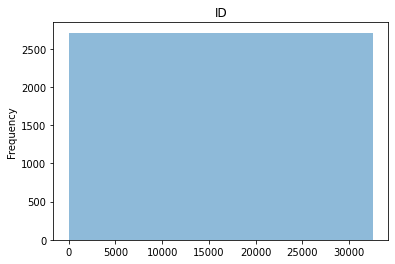

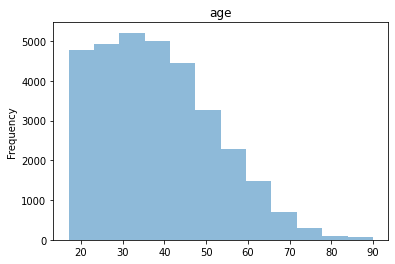

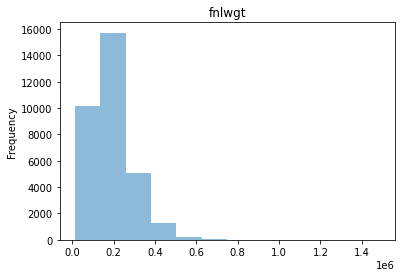

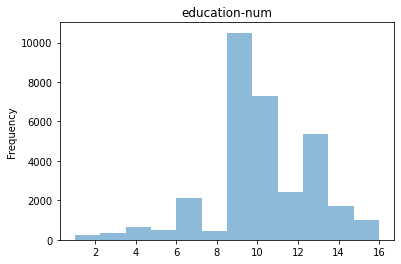

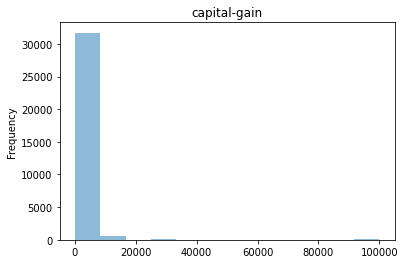

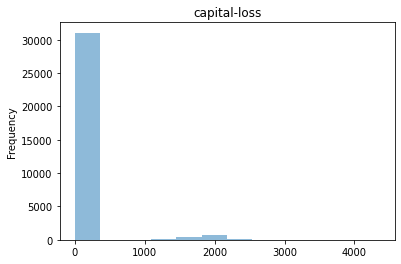

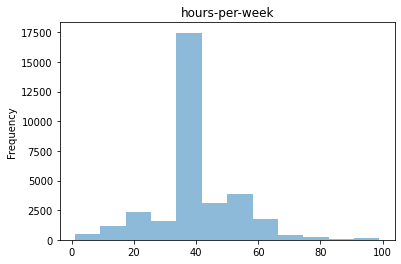

In [ ]:
for variable in numerical_columns:
  raw_df[variable].plot.hist(bins=12, alpha=0.5, title=variable)
  plt.show()

Capital loss needs to be further investigated. It is possible that the results we see here is due to the outliars.

In [ ]:
raw_df[raw_df['capital-loss'] == 0].shape[0]

31042

In [ ]:
raw_df[raw_df['capital-loss'] != 0].shape[0]

1519

In [ ]:
raw_df[raw_df['capital-loss'] != 0]['class'].value_counts()

>50K     773
<=50K    746
Name: class, dtype: int64

In [ ]:
raw_df[raw_df['capital-gain'] == 0].shape[0]

29849

In [ ]:
raw_df[raw_df['capital-gain'] != 0].shape[0]

2712

In [ ]:
raw_df[raw_df['capital-gain'] != 0]['class'].value_counts()

>50K     1677
<=50K    1035
Name: class, dtype: int64

It seems that capital loss and capital gain can be removed.

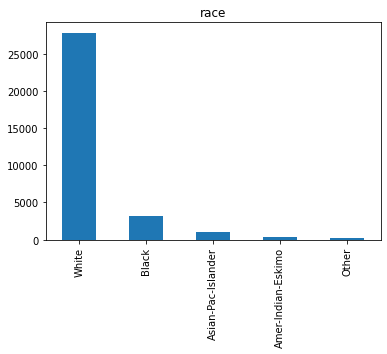

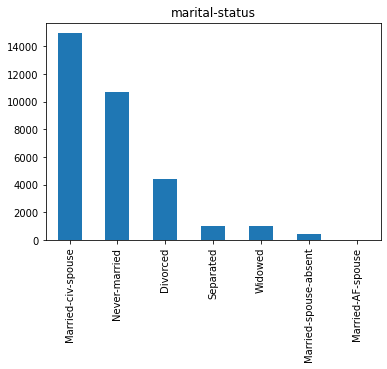

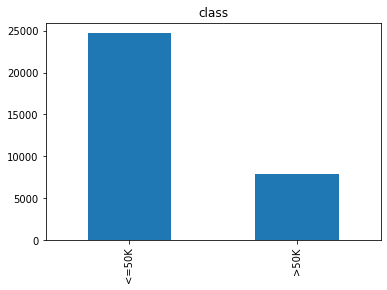

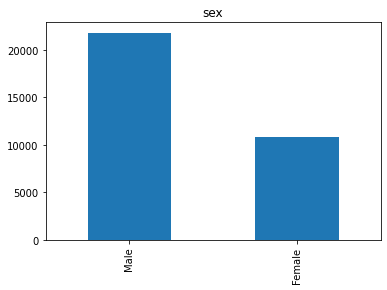

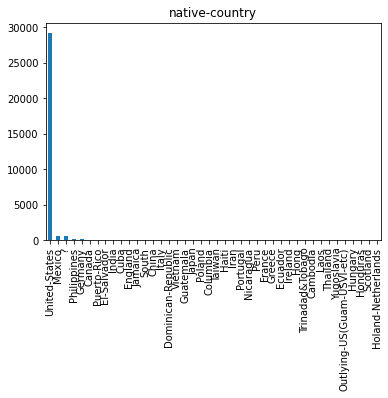

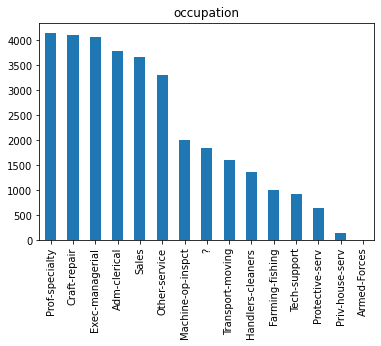

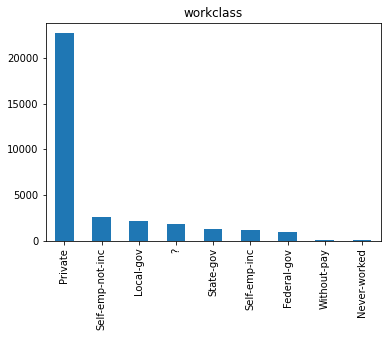

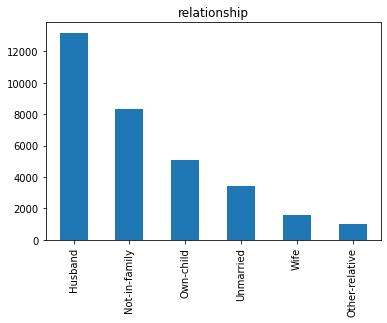

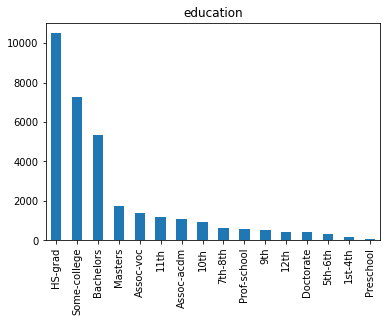

In [ ]:
for variable in categorical_columns:
  raw_df[variable].value_counts().plot(kind='bar', title=variable)
  plt.show()

native-country can be removed.
We might be able to remove race as well, lets have a closer look.

In [ ]:
raw_df[raw_df['race'] == 'Black']['class'].value_counts()

<=50K    2737
>50K      387
Name: class, dtype: int64

In [ ]:
raw_df[raw_df['race'] == 'White']['class'].value_counts()

<=50K    20699
>50K      7117
Name: class, dtype: int64

I will not drop race, it seems that it might make somewhat of a difference

Notice that workclass is a highly imballanced variable

In [ ]:
map_target = {'<=50K': 0, '>50K': 1}
raw_df['class_num'] = raw_df['class'].map(map_target)
average_class_by_occupation = raw_df.groupby(['occupation']).mean()['class_num']
average_class_by_occupation

occupation
?                    0.103635
Adm-clerical         0.134483
Armed-Forces         0.111111
Craft-repair         0.226641
Exec-managerial      0.484014
Farming-fishing      0.115694
Handlers-cleaners    0.062774
Machine-op-inspct    0.124875
Other-service        0.041578
Priv-house-serv      0.006711
Prof-specialty       0.449034
Protective-serv      0.325116
Sales                0.269315
Tech-support         0.304957
Transport-moving     0.200376
Name: class_num, dtype: float64

## Testing for correlation

We would like to test for correlation between all the different columns (irrelevant of their type).
An explanatory variable can potentially be ruled out in one of the following cases:
 - High variance between the variable and another explanatory variable 
 - Low variance between the variable and the target variable

### Numerical vs Numerical

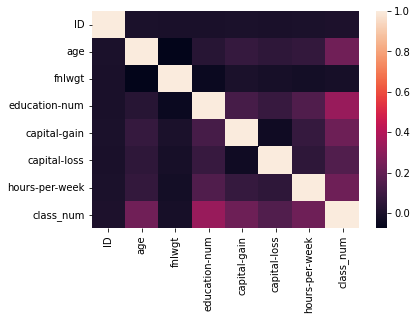

In [ ]:
sns.heatmap(raw_df.corr())

It seems that the numerical categoriesare not very strongly correlated with each other

TODO: 
 - get correlation between categorical->numerical and catigorical->categorical
 - for every column with missing data, count how many rows have missing data


### Categorical vs Numerical

In [ ]:
cat_num_corr_f_df = pd.DataFrame(columns=numerical_columns, index=categorical_columns)
cat_num_corr_p_df = pd.DataFrame(columns=numerical_columns, index=categorical_columns)

for numerical_variable, categorical_variable in itertools.product(numerical_columns, categorical_columns):
  # print(raw_df[numerical_variable][raw_df[categorical_variable]])
  groups = (raw_df[numerical_variable][raw_df[categorical_variable] == category] for category in unique_categorical_values[categorical_variable])
  F, p = stats.f_oneway(*groups)
  cat_num_corr_f_df[numerical_variable][categorical_variable] = F if F != float('inf') else 5000
  cat_num_corr_p_df[numerical_variable][categorical_variable] = p

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3349: RuntimeWarning: divide by zero encountered in double_scalars
  f = msb / msw


In [ ]:
cat_num_corr_f_df

,ID,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
race,0.505818,15.493,163.795,99.0479,4.46298,5.81001,24.4079
marital-status,0.269353,2659.74,16.1077,73.3478,41.5779,36.474,363.651
class,0.950753,1886.71,2.91559,4120.1,1709.15,754.83,1813.39
sex,0.1989,258.969,23.5035,4.91063,76.7029,67.7456,1807.06
native-country,1.2559,6.24223,20.4728,65.882,1.0088,2.26424,1.87712
occupation,1.56151,83.7469,7.1423,1043.4,33.7164,16.9631,249.712
workclass,0.767635,203.738,11.2978,164.89,44.7238,8.99856,223.513
relationship,1.16891,1889.03,9.0602,173.067,53.6684,50.467,692.594
education,1.25212,120.161,9.8161,5000,88.4118,21.5646,85.1091


In [ ]:
cat_num_corr_p_df

,ID,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
race,0.731478,1.14783e-12,4.46442e-139,6.04256e-84,0.00132167,0.00011378,3.36798e-20
marital-status,0.951407,0,1.34081e-18,2.83761e-91,8.44733e-51,2.61239e-44,0
class,0.329535,0,0.0877367,0,0,2.68655e-164,0
sex,0.655613,4.82399e-58,1.25258e-06,0.0266988,2.08121e-18,1.92868e-16,0
native-country,0.126381,1.01905e-32,1.84856e-147,0,0.454925,6.99666e-06,0.000575248
occupation,0.081584,3.521e-237,5.05079e-15,0,3.89617e-91,1.63136e-42,0
workclass,0.631434,0,4.10817e-16,6.88471e-274,5.05278e-72,2.04015e-12,0
relationship,0.321665,0,1.27762e-08,2.31271e-182,1.0876e-55,2.78826e-52,0
education,0.223869,0,9.76877e-24,0,4.97922e-268,1.52052e-59,8.67251e-258


5000.0


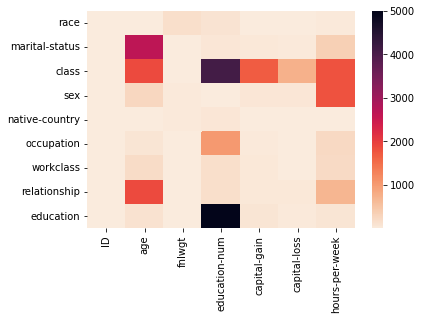

In [ ]:
cmap = sns.cm.rocket_r

stacked = cat_num_corr_f_df.stack()
min_value = stacked.min()
max_value = float(stacked.max())
print(max_value)
sns.heatmap(cat_num_corr_f_df.astype(float), vmin=min_value, vmax=max_value, cmap=cmap)

As expected, education is highly correlated with education-num (at first it actually got inf but I had to modify that in order for the heatmap to work).

Other correlated pairs of categorical-numerical variables:

Explanatory variables with themselves:
 - (marital-status, age)
 - (occupation, education-num)
 - (relationship, age)
 - (sex, hours-per-week)

Explanatory variables with target variable:
 - (class, age)
 - (class, education-num)
 - (class, capital-gain)
 - (class, hours-per-week)

We need to decide which variable we would like to keep, education or education-num. According to the one-way-ANOVA test, education-num is strongly correlated to class. since class is a categorical variable and education-num has a 1x1 correspondence with education, then education will be correlated as well.

In this case, I will chose the numeric value over the categorical value since I will be using a tree based method and with numerical values it can chose to make more robust splits this way.

capital-gain shows here some correlation with class, so we will not remove it.

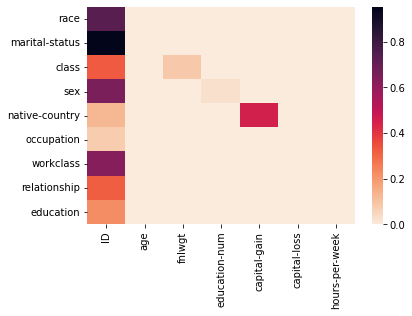

In [ ]:
sns.heatmap(cat_num_corr_p_df.astype(float), cmap=cmap)

p-values are nice and small for the correlated variables

Technically we should check that the test assumptions hold for each of the variables, but I will skip that for now:
 - Population distributions are normal
 - Samples have equal variances
 - Independence (we know this is true by design)

According to these results it seems I can drop fnlwgt as well

### Categorical vs Categorical

We will perform a chisquare test, the assumptions:
 - The two samples are independent
 - No expected cell count is = 0
 - No more than 20% of the cells have and expected cell count < 5

The last assumption needs to be tested for, we will skip it for now

In [ ]:
# taken from https://www.kaggle.com/akshay22071995/alone-in-the-woods-using-theil-s-u-for-survival

def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = stats.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [ ]:
chi2_df = pd.DataFrame(columns=categorical_columns, index=categorical_columns)
theil_df = pd.DataFrame(columns=categorical_columns, index=categorical_columns)
# cat_corr_p_df = pd.DataFrame(columns=categorical_columns, index=categorical_columns)
for cat1, cat2 in itertools.product(categorical_columns, categorical_columns):
  crosstab = pd.crosstab(raw_df[cat1], raw_df[cat2])
  x, _, _, _ = stats.chi2_contingency(crosstab)
  u = theil_u(raw_df[cat1].tolist(), raw_df[cat2].tolist())
  if cat1 == cat2:
    x = 40000
  chi2_df[cat1][cat2] = x
  theil_df[cat1][cat2] = u

In [ ]:
chi2_df

,race,marital-status,class,sex,native-country,occupation,workclass,relationship,education
race,40000,923.809,330.92,454.267,21814.8,850.866,412.537,1253.38,730.671
marital-status,923.809,40000,6517.74,6944.75,1043.11,3466.89,1413.56,38765.2,1638.14
class,330.92,6517.74,40000,1517.81,317.23,4031.97,1045.71,6699.08,4429.65
sex,454.267,6944.75,1517.81,40000,146.812,5863.75,768.914,13714.7,297.715
native-country,21814.8,1043.11,317.23,146.812,40000,2437.3,546.642,1184.86,8592.46
occupation,850.866,3466.89,4031.97,5863.75,2437.3,40000,41676.6,5194.64,15997.8
workclass,412.537,1413.56,1045.71,768.914,546.642,41676.6,40000,1586.37,2572.1
relationship,1253.38,38765.2,6699.08,13714.7,1184.86,5194.64,1586.37,40000,2449.23
education,730.671,1638.14,4429.65,297.715,8592.46,15997.8,2572.1,2449.23,40000


In [ ]:
theil_df

,race,marital-status,class,sex,native-country,occupation,workclass,relationship,education
race,1,0.0101149,0.01052,0.0104337,0.149887,0.00520771,0.00613326,0.0113131,0.00508451
marital-status,0.0232204,1,0.196548,0.178457,0.0181978,0.0220714,0.0190136,0.485827,0.0117716
class,0.0104889,0.0853641,1,0.0405918,0.00921316,0.0264217,0.0130897,0.0767564,0.0319275
sex,0.011962,0.0891223,0.0466752,1,0.00355024,0.0407383,0.0114281,0.182911,0.00233743
native-country,0.177108,0.00936657,0.0109185,0.00365902,1,0.0119689,0.00818461,0.00849977,0.0265862
occupation,0.0229299,0.0423325,0.116681,0.156456,0.0446001,1,0.285928,0.0563303,0.110078
workclass,0.0126543,0.0170883,0.0270869,0.0205662,0.0142913,0.133982,1,0.0163776,0.0160816
relationship,0.0305145,0.570817,0.207646,0.430329,0.0194026,0.0345075,0.0214107,1,0.0185421
education,0.01866,0.0188187,0.11752,0.0074823,0.0825746,0.0917504,0.0286053,0.0252287,1


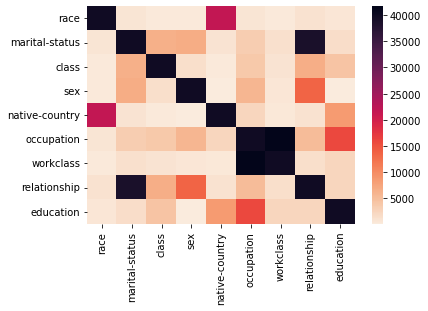

In [ ]:
sns.heatmap(chi2_df.astype(float), cmap=cmap)

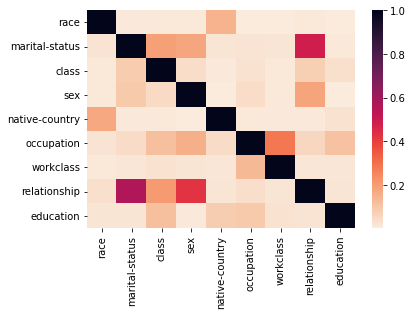

In [ ]:
sns.heatmap(theil_df.astype(float), cmap=cmap)

I used theils U since this gives the asymmetric correlation for categorical variables.

The nice thing is that chi2 and theils_u look very similar with the exception that in theils the symmetry is broken.

Pairs that are correlated:

Chi2

Explanatory vs Explanatory - 
 - (workclass, occupation)
 - (education, occupation)
 - (relationship, sex)
 - (race, native country) *
 - (marital-status, relationship) *

Explanatory vs Target - 
 - occupation
 - education
 - marital-status
 - relationship

 Theils U

 Explanatory vs Explanatory - asymmetric
  - (occupation, workclass) but not necessarily the other way - makes sense because there are more categories in occupation, this means that we might be able to get rid of workclass? although the correlation is not very strong.
  - (relationship, sex) but not necessarily the other way - for class, the relationship has a stronger correlation than sex.
  - (marital-status, relationship) about the same both ways
  - (education, occupation) but not so strong
  - (race, native-country) symmetric



 Explanatory vs Target - only one way (target to explanatory is not of interest)
 - occupation
 - education
 - marital-status
 - relationship

What we can get rid of:

 - native-country

race and native-country are symmetric so we can just select one
In the early tests we discovered that native-country is more redundant so we can get rid of it

 - marital-status
 
 relationship and marital status are strongly correlated symetrically and relationship has a stronger correlation with class

# Data Preperation

As we concluded in the EDA section, there are certain variables that we deffinitely want to get rid of:
 - native-country
 - capital-loss
 - capital-gain
 - education
 - fnlwgt
 - ID

As we saw earlier the following categorical variables have unknown values:
 - workclass
 - occupation

 Since we found that workclass and occupation are mildly correlated we can use each other to fill in the missing values if only one of them are missing.

We need to check if any numerical data has missing values and then we can treet them properly.

In [ ]:
np.count_nonzero(raw_df.isnull())

0

No missing data

In [ ]:
raw_df[(raw_df['occupation'] == '?') ^ (raw_df['workclass'] == '?')][['occupation', 'workclass']]

,occupation,workclass
5361,?,Never-worked
10845,?,Never-worked
14772,?,Never-worked
20337,?,Never-worked
23232,?,Never-worked
32304,?,Never-worked
32314,?,Never-worked


It seems pointless to fill in the missing values
We either have both workclass and occupation set as '?' or we have occupation set as '?' and workclass 'Never-worked' which means that there is no occupation.
Lets check other rows where workclass is 'Never-worked'.

In [ ]:
raw_df[raw_df['workclass'] == 'Never-worked'][['occupation']]

,occupation
5361,?
10845,?
14772,?
20337,?
23232,?
32304,?
32314,?


Conclusion: we will replace '?' with 'Unemployed'

In [ ]:
raw_df.loc[raw_df['workclass'] == 'Never-worked', 'occupation'] = 'Unemployed'

In [ ]:
raw_df[raw_df['workclass'] == 'Never-worked'][['occupation']]

,occupation
5361,Unemployed
10845,Unemployed
14772,Unemployed
20337,Unemployed
23232,Unemployed
32304,Unemployed
32314,Unemployed


In [ ]:
raw_df[raw_df['occupation'] == 'Unemployed']['workclass']

5361     Never-worked
10845    Never-worked
14772    Never-worked
20337    Never-worked
23232    Never-worked
32304    Never-worked
32314    Never-worked
Name: workclass, dtype: object

Since we will be dealing with tree based methods then the skewness of the data is of less importants to us, hence we will not be fixing the skew. 


There is one major issue, variables with many categories: occupation

native country is highly imballanced, it showed high correlation but that might be


In [ ]:
occupation_map = average_class_by_occupation.to_dict()
occupation_map

{'?': 0.10363537710255019,
 'Adm-clerical': 0.13448275862068965,
 'Armed-Forces': 0.1111111111111111,
 'Craft-repair': 0.22664064405952672,
 'Exec-managerial': 0.4840137727496311,
 'Farming-fishing': 0.11569416498993963,
 'Handlers-cleaners': 0.06277372262773723,
 'Machine-op-inspct': 0.12487512487512488,
 'Other-service': 0.04157814871016692,
 'Priv-house-serv': 0.006711409395973154,
 'Prof-specialty': 0.44903381642512075,
 'Protective-serv': 0.325115562403698,
 'Sales': 0.2693150684931507,
 'Tech-support': 0.30495689655172414,
 'Transport-moving': 0.20037570444583594}

In [ ]:
occupation_map = average_class_by_occupation.to_dict()
raw_df['occupation_class_average'] = raw_df['occupation'].map(occupation_map)
raw_df

,ID,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class,class_num,occupation_class_average
0,1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0,0.134483
1,2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0,0.484014
2,3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0,0.062774
3,4,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0,0.062774
4,5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0,0.449034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,0,0.304957
32557,32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,1,0.124875
32558,32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,0,0.134483
32559,32560,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,0,0.134483


In [ ]:
input_df = raw_df.drop(columns=['native-country', 'capital-loss', 'education', 'fnlwgt', 'ID', 'marital-status', 'workclass', 'class', 'occupation', 'race'])
input_df.head()

,age,education-num,relationship,sex,capital-gain,hours-per-week,class_num,occupation_class_average
0,39,13,Not-in-family,Male,2174,40,0,0.134483
1,50,13,Husband,Male,0,13,0,0.484014
2,38,9,Not-in-family,Male,0,40,0,0.062774
3,53,7,Husband,Male,0,40,0,0.062774
4,28,13,Wife,Female,0,40,0,0.449034


In [ ]:
input_df = pd.get_dummies(input_df)
input_df

,age,education-num,capital-gain,hours-per-week,class_num,occupation_class_average,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,sex_Female,sex_Male
0,39,13,2174,40,0,0.134483,0,1,0,0,0,0,0,1
1,50,13,0,13,0,0.484014,1,0,0,0,0,0,0,1
2,38,9,0,40,0,0.062774,0,1,0,0,0,0,0,1
3,53,7,0,40,0,0.062774,1,0,0,0,0,0,0,1
4,28,13,0,40,0,0.449034,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,12,0,38,0,0.304957,0,0,0,0,0,1,1,0
32557,40,9,0,40,1,0.124875,1,0,0,0,0,0,0,1
32558,58,9,0,40,0,0.134483,0,0,0,0,1,0,1,0
32559,22,9,0,20,0,0.134483,0,0,0,1,0,0,0,1


# Modeling

In [ ]:
y = input_df['class_num']
X = input_df.drop(columns='class_num') 

In [ ]:
y

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: class_num, Length: 32561, dtype: int64

In [ ]:
X

,age,education-num,capital-gain,hours-per-week,occupation_class_average,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,sex_Female,sex_Male
0,39,13,2174,40,0.134483,0,1,0,0,0,0,0,1
1,50,13,0,13,0.484014,1,0,0,0,0,0,0,1
2,38,9,0,40,0.062774,0,1,0,0,0,0,0,1
3,53,7,0,40,0.062774,1,0,0,0,0,0,0,1
4,28,13,0,40,0.449034,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,12,0,38,0.304957,0,0,0,0,0,1,1,0
32557,40,9,0,40,0.124875,1,0,0,0,0,0,0,1
32558,58,9,0,40,0.134483,0,0,0,0,1,0,1,0
32559,22,9,0,20,0.134483,0,0,0,1,0,0,0,1


We can now handle the imballanced data by sampling in a stratefied fasion

In [ ]:
y.unique()

array([0, 1])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y)


In [ ]:
 X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify=y_train) # 0.25 x 0.8 = 0.2

In [ ]:
print(f'test size: {y_test.size}, train size: {y_train.size}, validation: {y_val.size}')
# print(f'test size: {y_test.size}, train size: {y_train.size}')

test size: 6513, train size: 19536, validation: 6512


In [ ]:
# model = xgboost.XGBClassifier()
# kfold = KFold(n_splits=10, random_state=7)
# results = cross_val_score(model, X_train, Y_train, cv=kfold)
# print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0]	validation_0-error:0.160473	validation_0-logloss:0.642237	validation_1-error:0.162776	validation_1-logloss:0.642258
[1]	validation_0-error:0.156378	validation_0-logloss:0.600125	validation_1-error:0.161241	validation_1-logloss:0.600523
[2]	validation_0-error:0.156378	validation_0-logloss:0.565371	validation_1-error:0.161241	validation_1-logloss:0.565764
[3]	validation_0-error:0.156378	validation_0-logloss:0.535963	validation_1-error:0.161241	validation_1-logloss:0.536444
[4]	validation_0-error:0.15648	validation_0-logloss:0.511005	validation_1-error:0.161241	validation_1-logloss:0.511704
[5]	validation_0-error:0.15648	validation_0-logloss:0.489758	validation_1-error:0.161241	validation_1-logloss:0.490582
[6]	validation_0-error:0.15648	validation_0-logloss:0.471514	validation_1-error:0.161241	validation_1-logloss:0.472374
[7]	validation_0-error:0.155917	validation_0-logloss:0.455356	validation_1-error:0.160934	validation_1-logloss:0.456522
[8]	validation_0-error:0.155405	validation_

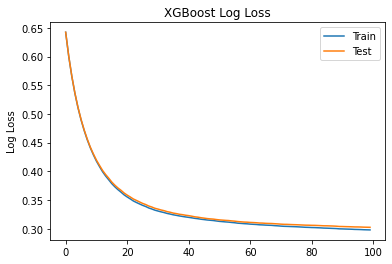

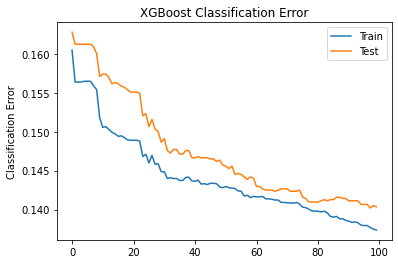

In [ ]:
model = xgb.XGBClassifier()
eval_set = [(X_train, y_train), (X_val, y_val)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

# make predictions for test data
y_pred = model.predict(X_val)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [ ]:
test_preds = model.predict(X_test)

In [ ]:
len(test_preds)

6513

In [ ]:
print(f'{X_test.shape} {y_test.size}')

(6513, 13) 6513


In [ ]:
test_preds = [round(value) for value in test_preds]

# evaluate predictions
accuracy = accuracy_score(y_test, test_preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 85.69%


Considering out baseline of ~ 76% accuracy with a simple model that allways predicts a singe class this is not a good enough improvement.

The good news is that the accuracy on the test set and the accuracy on the validation set are very similar.

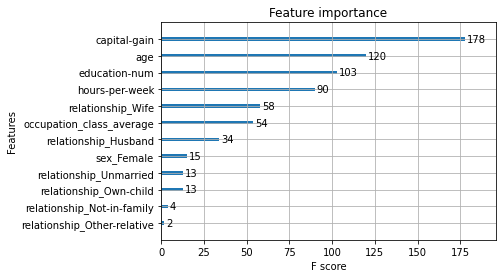

In [ ]:
plot_importance(model)
plt.show()

# Conclusion

We found interesting relationships between variables that would be interesting to further investigate.

We removed redundant variables, we created dummy variables, we engineered some features to have more suiting values.

If I would have more time, I would try different subsets of models and perhaps train the model for more epochs and find the point in which it overfits as well as play with hyper parameters and try other tree-based models or perhaps a logistic regression.

We reached an accuracy of ~85.6% which is better than random and than predicting a single class and seems quite general since we tested it on two seperate test sets and both had the same accuracy.

It would be interesting to check:
- Dig a little deaper into feature importance
- Dig into the predictions to see if the model did anything too simple